# Natural scenes classification (intel dataset, contains 6 classes: buildings, forest, glacier, mountain, sea, street) 


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import os
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc, recall_score, accuracy_score, precision_score, f1_score
from typing import List, Dict, Tuple, Callable
from copy import deepcopy
import copy

Read(create) data

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
data_dir = 'drive/MyDrive/intel_places_ds'

In [10]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [11]:
image_data = {x: datasets.ImageFolder(os.path.join(data_dir, "seg_" + x + "/seg_" + x ),
                                          data_transforms[x])
                  for x in ['train', 'test']}

class_names = image_data['train'].classes

data_size = {x: len(image_data[x]) for x in ['train', 'test']}

batch_size=64
dataloaders = {x: torch.utils.data.DataLoader(image_data[x], batch_size=batch_size, shuffle=True, num_workers=8)   
               for x in ['train', 'test']}

print(data_size)
print(device)
print(class_names)

{'train': 14034, 'test': 3000}
cuda:0
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Using pre-trained model to quickly obtain cutting-edge results
VGG

In [12]:
vgg16 = models.vgg16(pretrained=True)
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [13]:
for param in vgg16.parameters():    
  param.requires_grad = False

In [14]:
vgg16.classifier[6] = nn.Linear(4096, len(class_names))
vgg16.classifier.add_module('7', nn.LogSoftmax(dim=1))
if torch.cuda.is_available():
    vgg16.cuda()
criterion = nn.NLLLoss()
optimizer = optim.Adam(vgg16.parameters())

In [15]:
summary(vgg16, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

Train model

In [17]:
def train_model(base_model, criterion, optimizer, num_epochs=5):    
  best_model_wts = copy.deepcopy(base_model.state_dict())
  best_acc = 0.0
  loss_list=[]
  acc=[]
  for epoch in range(num_epochs):
    train_loss = 0.0
    train_acc = 0
    
    print('Epoch {}/{}'.format(epoch + 1, num_epochs))
    print('-' * 10)

    base_model.train()

    for img, labels in dataloaders['train']:
      img, labels = img.cuda(), labels.cuda()
      img = img.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      output = base_model(img)
      loss = criterion(output, labels)
      loss.backward()
      optimizer.step()
      train_loss += loss.item() * img.size(0)
      _, pred = torch.max(output, dim=1)
      correct_tensor = pred.eq(labels.data.view_as(pred))
      accuracy = torch.mean(correct_tensor.type(torch.cuda.FloatTensor))
      train_acc += accuracy.item() * img.size(0)
 
    train_loss = train_loss / len(image_data['train']) 
    train_acc = train_acc / len(dataloaders['train'].dataset)
    loss_list.append(train_loss)
    acc.append(train_acc)
    print(f'Training Loss: {train_loss:.4f}')
    print(f'Training Accuracy: {100 * train_acc:.2f}')
    if epoch >= 1:
      if train_loss > loss_list[-2]:
        #return best_model_wts, loss_list
        best_model_wts = copy.deepcopy(base_model.state_dict())
    
  #return base_model, loss_list
  base_model.load_state_dict(best_model_wts)
  return base_model

In [18]:
trained_model = train_model(vgg16, criterion, optimizer)

Epoch 1/5
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training Loss: 0.4520
Training Accuracy: 82.84
Epoch 2/5
----------
Training Loss: 0.3874
Training Accuracy: 85.24
Epoch 3/5
----------
Training Loss: 0.3850
Training Accuracy: 85.70
Epoch 4/5
----------
Training Loss: 0.3917
Training Accuracy: 85.34
Epoch 5/5
----------
Training Loss: 0.3872
Training Accuracy: 85.36


In [19]:
def predict():
  all_preds = torch.tensor([]).to(device)
  true_vals = torch.tensor([]).to(device)
  test_acc=0
  with torch.no_grad():
    for (X, y) in dataloaders['test']:
      X, y = X.to(device), y.to(device)
      true_vals = torch.cat((true_vals, y), 0)
      pred = trained_model(X)
      _, pred = torch.max(pred, dim=1)
      all_preds = torch.cat((all_preds, pred), 0)

      correct_tensor = pred.eq(y.data.view_as(pred))
      accuracy = torch.mean(correct_tensor.type(torch.cuda.FloatTensor))
      test_acc += accuracy.item()* X.size(0)
    
      
    test_acc = test_acc / len(dataloaders['test'].dataset)
    print(f'    Testing Accuracy: { test_acc:.2f}')
    return all_preds.cpu().numpy(), true_vals.cpu().numpy()
      
outputs, labels = predict()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


    Testing Accuracy: 0.90


In [20]:
'''def build_classifier(num_in_features, hidden_layers, num_out_features):       
  classifier = nn.Sequential()    
  if hidden_layers == None:        
    classifier.add_module('fc0', nn.Linear(num_in_features, 102))           
  return classifier'''

"def build_classifier(num_in_features, hidden_layers, num_out_features):       \n  classifier = nn.Sequential()    \n  if hidden_layers == None:        \n    classifier.add_module('fc0', nn.Linear(num_in_features, 102))           \n  return classifier"

# Classification report and ROC curves

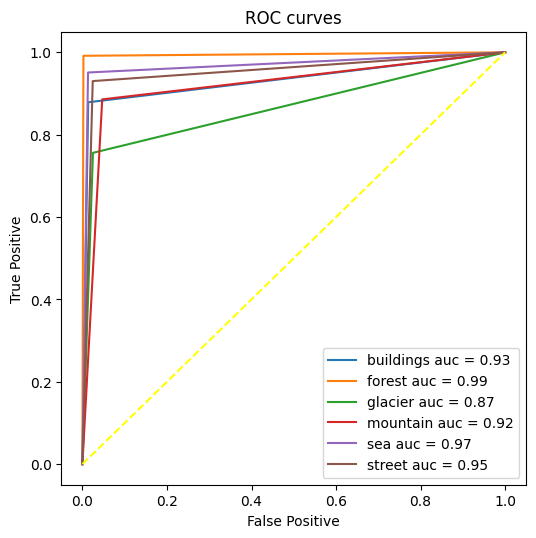

In [21]:
lab_plt = [(labels == i).astype(float) for i in range(6)]
outs_plt = [(outputs == i).astype(float) for i in range(6)]
fpr = {}
tpr = {}
roc_auc = {}
for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(lab_plt[i], outs_plt[i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure (figsize = (6, 6), dpi = 100)
for i in range(6):
  plt.plot(fpr[i], tpr[i], label = f'{class_names[i]} auc = {roc_auc[i]:.2f}' )
plt.legend(loc = 'best')
plt.plot([0,1], [0,1], color='yellow', linestyle='--')
plt.title('ROC curves')
plt.ylabel('True Positive')
plt.xlabel('False Positive')
plt.show()

In [22]:
print(classification_report(labels, outputs, target_names=class_names))

              precision    recall  f1-score   support

   buildings       0.92      0.88      0.90       437
      forest       0.99      0.99      0.99       474
     glacier       0.87      0.76      0.81       553
    mountain       0.80      0.89      0.84       525
         sea       0.94      0.95      0.94       510
      street       0.88      0.93      0.91       501

    accuracy                           0.90      3000
   macro avg       0.90      0.90      0.90      3000
weighted avg       0.90      0.90      0.90      3000



# Visualizing model predictions

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


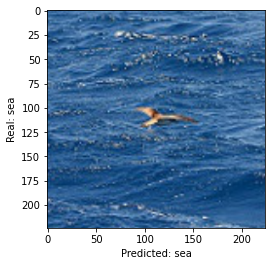

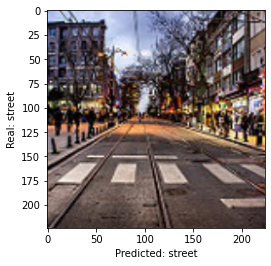

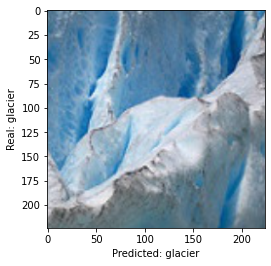

In [34]:
k = 0
n=3
for img, lab in dataloaders['test']: 
  image = img 
  img = img.to(device)
  pred = trained_model(img)
  _, pred = torch.max(pred, dim=1)
  k += 1
  for i in range(n):
    inp = torchvision.utils.make_grid(image[i]).numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.ylabel('Real: {}'.format(class_names[lab[i]]))
    plt.xlabel('Predicted: {}'.format(class_names[pred[i]]))
    plt.imshow(inp)
  plt.show()
  if k == n:
      break
  